In [32]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sp
from scipy import stats
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [131]:
#function that reads the data, turning it into a pandas dataframe
def read_csv(filename):
    dat = pd.read_csv(filename, sep = ',', header = 13, names = ["Time (s)", "voltage (V)"]) 
    return dat

def polynomial(x, a, b, c): #polynomisk function til fit
    return a + x * b + 0.5 * x**2 * c

#function for calculating acceleration on a dataset. returns acceleration a [WIP]
def acceleration_calc(filename, theta, D_ball, D_rail, D_sensor, eD_sensor): #string, float, float, float, list of floats, list of floats

    dat = read_csv(filename)
    peaks = sp.find_peaks(dat["voltage (V)"], height = 4, distance = 100)
    time = []
    for i in peaks[0]: #find tiderne hvor vi passerer, laver liste fra første gate til sidste.
        time.append(dat["Time (s)"][i])
    time = np.array(time)
    least_squares = LeastSquares(time, D_sensor, eD_sensor, polynomial) #for the minuit least squares fitting function. use chisquare instead?
    m = Minuit(least_squares, a=0, b=0, c=0)
    m.migrad()
    m.hesse()
    acc = m.values[2]
    
    #plot the data with fit, maybe remove when we are confident everything works
    plt.errorbar(time, D_sensor, eD_sensor, fmt="o", label="data") #plot data
    plt.plot(time, polynomial(time, *m.values), label="fit") #plot fitted line
    # display legend with some fit info
    fit_info = [
        f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(time) - m.nfit}",
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    plt.legend(title="\n".join(fit_info));
    return acc

#weighted mean calculation, returns weighted mean, error on the mean, chi2, and chi2 probability.
def w_mean(data, err): 
    mean_weighted = np.sum(data/(err**2))/np.sum(1/err**2)
    err_weighted = np.sqrt(1/np.sum(1/err**2))
    chi2 = np.sum(((data - mean_weighted) / err)**2)
    n = len(data)
    chi2_prob = stats.chi2.sf(chi2, n)
    return [mean_weighted, err_weighted, chi2, chi2_prob]

#mean calculation, calculating the statistical error
def mean(data):
    mean = np.sum(data)/len(data)
    datasq = np.sum(data**2)/len(data)   #the mean of the square data, for the rho calculation
    rho = np. sqrt(datasq - mean**2)
    return mean, rho


#function for calculating positions of sensors
def sensor_position(D_sensor): #input a pd dataframe. output a 2d dataframe of sensor positions, error, chi2 and chi2prob
    sensor_positions = pd.DataFrame(data = [], index = ["D", "eD", "chi2", "chi2_prob"])
    sensor_positions.insert(0, "gate1", w_mean(D_sensor["gate1"], D_sensor["egate1"]))
    sensor_positions.insert(1, "gate2", w_mean(D_sensor["gate2"], D_sensor["egate2"]))
    sensor_positions.insert(2, "gate3", w_mean(D_sensor["gate3"], D_sensor["egate3"]))
    sensor_positions.insert(3, "gate4", w_mean(D_sensor["gate4"], D_sensor["egate4"]))
    sensor_positions.insert(4, "gate5", w_mean(D_sensor["gate5"], D_sensor["egate5"]))
    
    return sensor_positions
    

#function for looping over all files in a directory

In [139]:
print(w_mean(D_sensor["gate1"], D_sensor["egate1"]))
mean(D_sensor["gate1"])

[22.578275862068963, 0.05570860145311556, 0.1379310344827616, 0.99964218629083]


(22.586000000000002, 0.019595917942184574)

In [138]:
#make pd. dataframes containing measured lengths
#photogate placement
gate1 = [22.6, 22.6, 22.6, 22.55, 22.58]
gate2 = [39.15, 39.15, 39.2, 39.15, 39.19]
gate3 = [56.75, 56.8, 56.85, 56.75, 56.81]
gate4 = [73.3, 73.25, 73.35, 73.26, 73.24]
gate5 = [90.9, 90.85, 91.1, 90.9, 90.88]
egate1 = [0.3, 0.1, 0.3, 0.1, 0.1]
egate2 = [0.3, 0.1, 0.3, 0.1, 0.1]
egate3 = [0.3, 0.05, 0.3, 0.1, 0.1]
egate4 = [0.3, 0.05, 0.3, 0.1, 0.1]
egate5 = [0.3, 0.1, 0.3, 0.1, 0.1]

#D_sensor = pd.DataFrame(data = [gate1, egate1, gate2, egate2, gate3, egate3, gate4, egate4, gate5, egate5], index = ["gate1", "egate1", "gate2", "egate2", "gate3", "egate3", "gate4", "egate4", "gate5", "egate5", ])
D_sensor = pd.DataFrame(data = [], index = [])
D_sensor.insert(0, "gate1", gate1)
D_sensor.insert(1, "egate1", egate1)
D_sensor.insert(2, "gate2", gate2)
D_sensor.insert(3, "egate2", egate2)
D_sensor.insert(4, "gate3", gate3)
D_sensor.insert(5, "egate3", egate3)
D_sensor.insert(6, "gate4", gate4)
D_sensor.insert(7, "egate4", egate4)
D_sensor.insert(8, "gate5", gate5)
D_sensor.insert(9, "egate5", egate5)


#width of rail
width_rail = [0.612, 0.628, 0.605, 0.6, 0.63]
ewidth_rail = [0.04, 0.05, 0.03, 0.05, 0.05]

D_rail = pd.DataFrame(data = [], index = [])
D_rail.insert(0, "D_rail", width_rail)
D_rail.insert(1, "eD_rail", ewidth_rail)

#angles
theta_f = [14.3, 14.3, 14.3, 14.1, 14.3]
etheta_f = [0.5, 0.5, 0.2, 0.5, 0.5]
theta_s = [13.1, 13.15, 13.1, 13.2, 13.0]
etheta_s = [0.3, 0.5, 0.2, 0.3, 0.2]
theta = pd.DataFrame(data = [], index = [])
theta.insert(0, "theta_f", theta_f)
theta.insert(1, "etheta_f", etheta_f)
theta.insert(2, "theta_s", theta_s)
theta.insert(3, "etheta_s", etheta_s)

#ball sizes

D_ball_xs = [1.2, 1.2, 1.2, 1.2, 1.2]
eD_ball_xs = [0.01, 0.04, 0, 0.01, 0.02]
D_ball_s = [1.24, 1.258, 1.23, 1.25, 1.25]
eD_ball_s = [0.02, 0.04, 0.05, 0.03, 0.03]
D_ball_l = [1.48, 1.48, 1.49, 1.488, 1.491]
eD_ball_l = [0.05, 0.03, 0.04, 0.03, 0.04]

D_balls = pd. DataFrame(data = [], index = [])
D_balls.insert(0, "D_ball_l", D_ball_l)
D_balls.insert(1, "eD_ball_l", eD_ball_l)
D_balls.insert(2, "D_ball_s", D_ball_s)
D_balls.insert(3, "eD_ball_s", eD_ball_s)
D_balls.insert(4, "D_ball_xs", D_ball_xs)
D_balls.insert(5, "eD_ball_xs", eD_ball_xs)



185.0621396243953


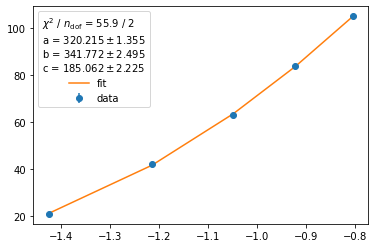

In [4]:

filename = "Anders_L_fp.csv" #filename of the file to load
path = "../Data/Incline/"    #path to the data
D_sensor = [21.0, 42.0, 63.0, 84.0, 105.0] #sensor placement . These are example, should use proper data
eD_sensor = [0.1, 0.1, 0.1, 0.1, 0.1] #sensor placement error. These are example, should use proper data

stuff = acceleration_calc(path + filename, 0, 0, 0, D_sensor, eD_sensor)
print(stuff)

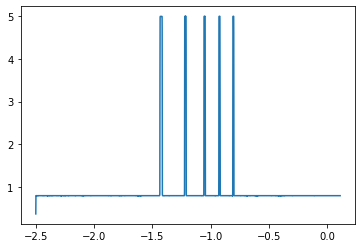

In [5]:
dat = read_csv(path + filename)
plt.plot(dat["Time (s)" ], dat["voltage (V)"])